# MNIST - NN - PyTorch

- [Сургалтанд шаардлагатай зүйлс](#Сургалтанд-шаардлагатай-зүйлс)
    * [Сургалтын өгөгдөл унших](#Сургалтын-өгөгдөл-унших)
    * [Accuracy тооцоолох функц](#Accuracy-тооцоолох-функц)
    * [Сургалт явуулах ерөнхий функц](#Сургалт-явуулах-ерөнхий-функц)
- [Сургалт](#Сургалт)
    * [1. Энгийн Neural Network](#1.-Энгийн-Neural-Network)
    * [2. Энгийн Neural Network (sigmoid)](#2.-Энгийн-Neural-Network-(sigmoid))
    * [3. Олон давхаргатай Neural Network](#3.-Олон-давхаргатай-Neural-Network)
    * [4. Neural Network with Dropout](#4.-Neural-Network-with-Dropout)

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Сургалтанд шаардлагатай зүйлс

### Сургалтын өгөгдөл унших

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,)),])

trainset = datasets.MNIST('.', download=False, train=True, transform=transform)
testset = datasets.MNIST('.', download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=150, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=150, shuffle=True)
print('Сургах өгөгдөл:', len(trainset))
print('Шалгах өгөгдөл:', len(testset))
print('Batch тоо:', len(trainloader))
batch_count = len(trainloader)

Сургах өгөгдөл: 60000
Шалгах өгөгдөл: 10000
Batch тоо: 400


### Accuracy тооцоолох функц

In [3]:
def get_accuracy(predicted, target):
    equals = predicted.max(1)[1] == target
    return torch.mean(equals.type(torch.FloatTensor)).item()

### Сургалт явуулах ерөнхий функц

**Параметрууд**
- `model` - сургах модель
- `criterion` - loss функц
- `optimizer` - optimizer
- `epoch` - epoch тоо

**Буцаах утга**
- `model` - сургасан модель
- `train_losses` - сургалтын өгөгдлийн loss
- `test_losses` - туршилтын өгөгдлийн loss

In [4]:
def train(model, criterion, optimizer, epoch):
    train_losses, test_losses = [], []

    for e in range(epoch):
        batch_n = 1
        epoch_loss = 0
        epoch_accuracy = 0
        print(f'Epoch: {e+1}/{epoch}')

        for images, labels in trainloader:
            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_accuracy += get_accuracy(log_ps, labels)

            helper.print_progress(batch_n, batch_count, loss=epoch_loss/batch_n, accuracy=epoch_accuracy*(100/batch_n))
            batch_n += 1
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    accuracy += get_accuracy(ps, labels)
            model.train()

            train_losses.append(epoch_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print("\n\tTraining Loss: {:.3f}.. ".format(epoch_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}\n".format(accuracy/len(testloader)))
    return model, train_losses, test_losses

## Сургалт

### 1. Энгийн Neural Network

1 Hidden Layer

**Model:** Input(784) -> Linear(250) -> ReLU -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [11]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 250
# Гаралт
output_size = 10

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [13]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=15)

Epoch: 1/15
[============================================================] 100.0% 400/400 loss*: 0.340 accuracy*: 90.087%
	Training Loss: 0.340..  Test Loss: 0.149..  Test Accuracy: 0.955

Epoch: 2/15
[============================================================] 100.0% 400/400 loss*: 0.129 accuracy*: 96.265%
	Training Loss: 0.129..  Test Loss: 0.108..  Test Accuracy: 0.967

Epoch: 3/15
[============================================================] 100.0% 400/400 loss*: 0.088 accuracy*: 97.370%
	Training Loss: 0.088..  Test Loss: 0.090..  Test Accuracy: 0.972

Epoch: 4/15
[============================================================] 100.0% 400/400 loss*: 0.067 accuracy*: 98.035%
	Training Loss: 0.067..  Test Loss: 0.080..  Test Accuracy: 0.975

Epoch: 5/15
[============================================================] 100.0% 400/400 loss*: 0.054 accuracy*: 98.392%
	Training Loss: 0.054..  Test Loss: 0.086..  Test Accuracy: 0.972

Epoch: 6/15
[==========================================

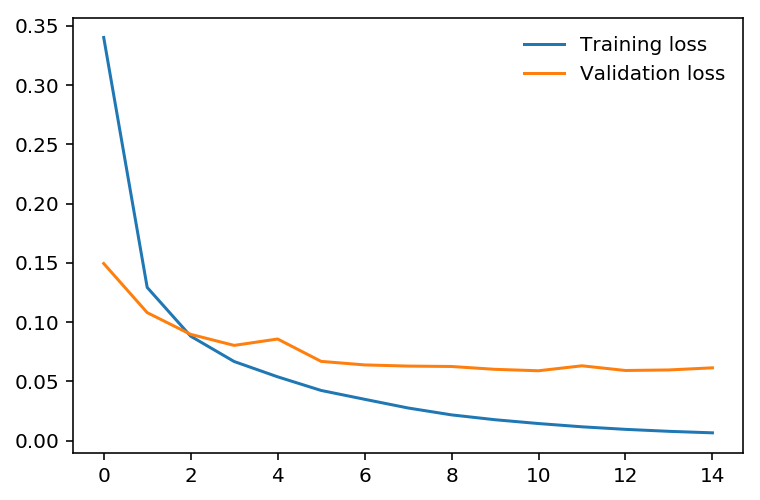

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 2. Энгийн Neural Network (sigmoid)

1 Hidden Layer

**Model:** Input(784) -> Linear(250) -> Sigmoid -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [15]:
# Оролт
input_size = 784
# Нуугдмал давхарга
hidden_size = 250
# Гаралт
output_size = 10

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [17]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [18]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=15)

Epoch: 1/15
[============================================================] 100.0% 400/400 loss*: 0.593 accuracy*: 82.037%
	Training Loss: 0.593..  Test Loss: 0.294..  Test Accuracy: 0.914

Epoch: 2/15
[============================================================] 100.0% 400/400 loss*: 0.294 accuracy*: 91.372%
	Training Loss: 0.294..  Test Loss: 0.257..  Test Accuracy: 0.925

Epoch: 3/15
[============================================================] 100.0% 400/400 loss*: 0.251 accuracy*: 92.748%
	Training Loss: 0.251..  Test Loss: 0.222..  Test Accuracy: 0.936

Epoch: 4/15
[============================================================] 100.0% 400/400 loss*: 0.215 accuracy*: 93.785%
	Training Loss: 0.215..  Test Loss: 0.196..  Test Accuracy: 0.944

Epoch: 5/15
[============================================================] 100.0% 400/400 loss*: 0.186 accuracy*: 94.590%
	Training Loss: 0.186..  Test Loss: 0.173..  Test Accuracy: 0.949

Epoch: 6/15
[==========================================

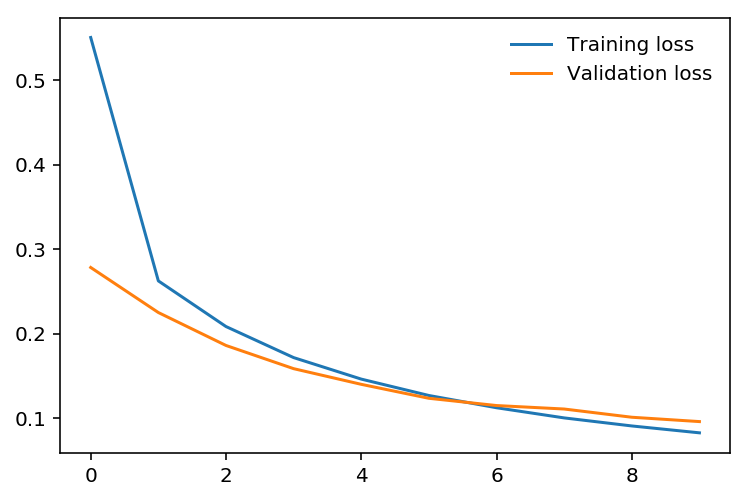

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 3. Олон давхаргатай Neural Network

2 Hidden Layer

**Model:** Input(784) -> Linear(250) -> ReLU -> Linear(100) -> ReLU -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [19]:
input_size = 784
hidden_sizes = [250, 100]
output_size = 10

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [22]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=15)

Epoch: 1/15
[============================================================] 100.0% 400/400 loss*: 0.386 accuracy*: 88.543%
	Training Loss: 0.386..  Test Loss: 0.151..  Test Accuracy: 0.952

Epoch: 2/15
[============================================================] 100.0% 400/400 loss*: 0.113 accuracy*: 96.557%
	Training Loss: 0.113..  Test Loss: 0.095..  Test Accuracy: 0.971

Epoch: 3/15
[============================================================] 100.0% 400/400 loss*: 0.077 accuracy*: 97.685%
	Training Loss: 0.077..  Test Loss: 0.092..  Test Accuracy: 0.972

Epoch: 4/15
[============================================================] 100.0% 400/400 loss*: 0.055 accuracy*: 98.257%
	Training Loss: 0.055..  Test Loss: 0.069..  Test Accuracy: 0.978

Epoch: 5/15
[============================================================] 100.0% 400/400 loss*: 0.043 accuracy*: 98.618%
	Training Loss: 0.043..  Test Loss: 0.070..  Test Accuracy: 0.979

Epoch: 6/15
[==========================================

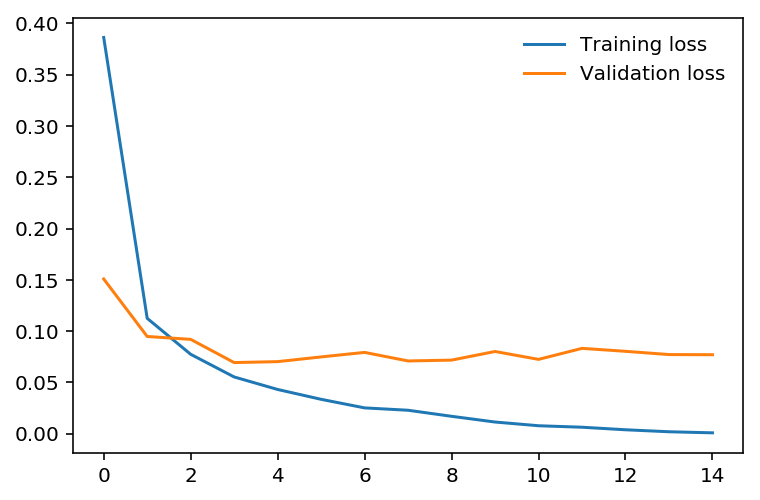

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### 4. Neural Network with Dropout

2 Hidden Layer + Dropout

**Model:** Input(784) -> Linear(250) -> ReLU -> Dropout(0.2) -> Linear(100) -> ReLU -> Dropout(0.2) -> Linear(10) -> Softmax

**Loss:** Negative Log Likelihood Loss

**Optimizer:** Stochastic Gradient Descend, `lr=0.07`, `momentum=0.9`

**Training**: `epoch=15`, `batch_size=150`

In [24]:
input_size = 784
hidden_sizes = [250, 100]
output_size = 10

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_sizes[1], output_size),
                                    nn.LogSoftmax(dim=1))
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return x

In [26]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)

In [27]:
model, train_losses, test_losses = train(model, criterion, optimizer, epoch=15)

Epoch: 1/15
[============================================================] 100.0% 400/400 loss*: 0.420 accuracy*: 87.172%
	Training Loss: 0.420..  Test Loss: 0.156..  Test Accuracy: 0.951

Epoch: 2/15
[============================================================] 100.0% 400/400 loss*: 0.145 accuracy*: 95.540%
	Training Loss: 0.145..  Test Loss: 0.098..  Test Accuracy: 0.970

Epoch: 3/15
[============================================================] 100.0% 400/400 loss*: 0.107 accuracy*: 96.730%
	Training Loss: 0.107..  Test Loss: 0.079..  Test Accuracy: 0.976

Epoch: 4/15
[============================================================] 100.0% 400/400 loss*: 0.089 accuracy*: 97.220%
	Training Loss: 0.089..  Test Loss: 0.074..  Test Accuracy: 0.976

Epoch: 5/15
[============================================================] 100.0% 400/400 loss*: 0.077 accuracy*: 97.612%
	Training Loss: 0.077..  Test Loss: 0.068..  Test Accuracy: 0.979

Epoch: 6/15
[==========================================

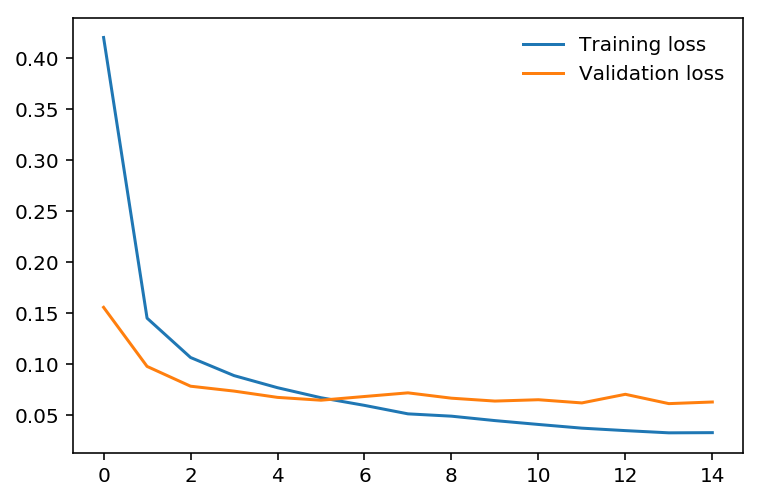

In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)